# Laplacian Eigenmaps for Recurrence Matrices (LERM)

Here we reproduce the figures displaying the LERM analysis. The computations themselves were done on [CARC](https://www.carc.usc.edu/) machines. See [James et al. 2024](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2023PA004700) for details on the method.

In [2]:
import pickle
import os

from tqdm import tqdm

import ammonyte as ammo
import pyleoclim as pyleo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches

from matplotlib.ticker import FormatStrFormatter

/Users/alexjames/miniconda3/envs/ammonyte/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
def detect_transitions(series,transition_interval=None):
    '''Function to detect transitions across a confidence interval
    
    Parameters
    ----------
    
    series : pyleo.Series, amt.Series
        Series to detect transitions upon
        
    transition_interval : list,tuple
        Upper and lower bound for the transition interval
    
    Returns
    -------
    
    transitions : list
        Timing of the transitions of the series across its confidence interval
    '''
    series_fine = series.interp(step=1)
    
    if transition_interval is None:
        upper, lower = ammo.utils.sampling.confidence_interval(series)
    else:
        upper, lower = transition_interval

    above_thresh = np.where(series_fine.value > upper,1,0)
    below_thresh = np.where(series_fine.value < lower,1,0)

    transition_above = np.diff(above_thresh)
    transition_below = np.diff(below_thresh)

    upper_trans = series_fine.time[1:][np.diff(above_thresh) != 0]
    lower_trans = series_fine.time[1:][np.diff(below_thresh) != 0]

    full_trans = np.zeros(len(transition_above))

    last_above = 0
    last_below = 0
    for i in range(len(transition_above)):
        above = transition_above[i]
        below = transition_below[i]
        if above != 0:
            if last_below+above == 0:
                loc = int((i+below_pointer)/2)
                full_trans[loc] = 1
                last_below=0
            last_above = above
            above_pointer = i
        if below != 0:
            if last_above + below == 0:
                loc = int((i+above_pointer)/2)
                full_trans[loc] = 1
                last_above=0
            last_below = below
            below_pointer = i

    transitions = series_fine.time[1:][full_trans != 0]
    
    return transitions

In [4]:
with open('../data/palette_dict.pkl','rb') as handle:
    palette_dict = pickle.load(handle)

with open('../data/preprocessed_series_dict.pkl','rb') as handle:
    preprocessed_series_dict = pickle.load(handle)

with open('../data/preprocessed_ens_dict.pkl','rb') as handle:
    preprocessed_ens_dict = pickle.load(handle)

lat_dict = {series.lat:series.label for series in preprocessed_series_dict.values()}

sort_index = np.sort(np.array(list(lat_dict.keys())))[::-1]
sort_label = [lat_dict[lat] for lat in sort_index]
preprocessed_series_dict = {label:preprocessed_series_dict[label] for label in sort_label} #Sort by latitude

keys = list(preprocessed_series_dict.keys())
file_dict = {key:[] for key in keys}

for key in file_dict.keys():
    with open(f'../carc/lerm/data/m_dict_{key}.pkl','rb') as handle:
        m_dict = pickle.load(handle)
    for m,tau_list in m_dict.items():
        for tau in tau_list:
            file_dict[key].append(f'lerm_ens_{key}_{m}_{tau}.pkl')

In [5]:
# Loading the data files with lerm output
data_path = '../carc/lerm/data'
lerm_ens = {}

for label,file_list in file_dict.items():
    file_path = file_list[4] #m = 10, tau = first min of MI
    with open(f'{data_path}/{file_path}','rb') as handle:
        ens = pickle.load(handle)
    lerm_ens[label] = ens

/Users/alexjames/miniconda3/envs/ammonyte/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/alexjames/miniconda3/envs/ammonyte/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/alexjames/miniconda3/envs/ammonyte/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/alexjames/miniconda3/envs/ammonyte/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/alexjames/miniconda3/envs/ammonyte/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nan

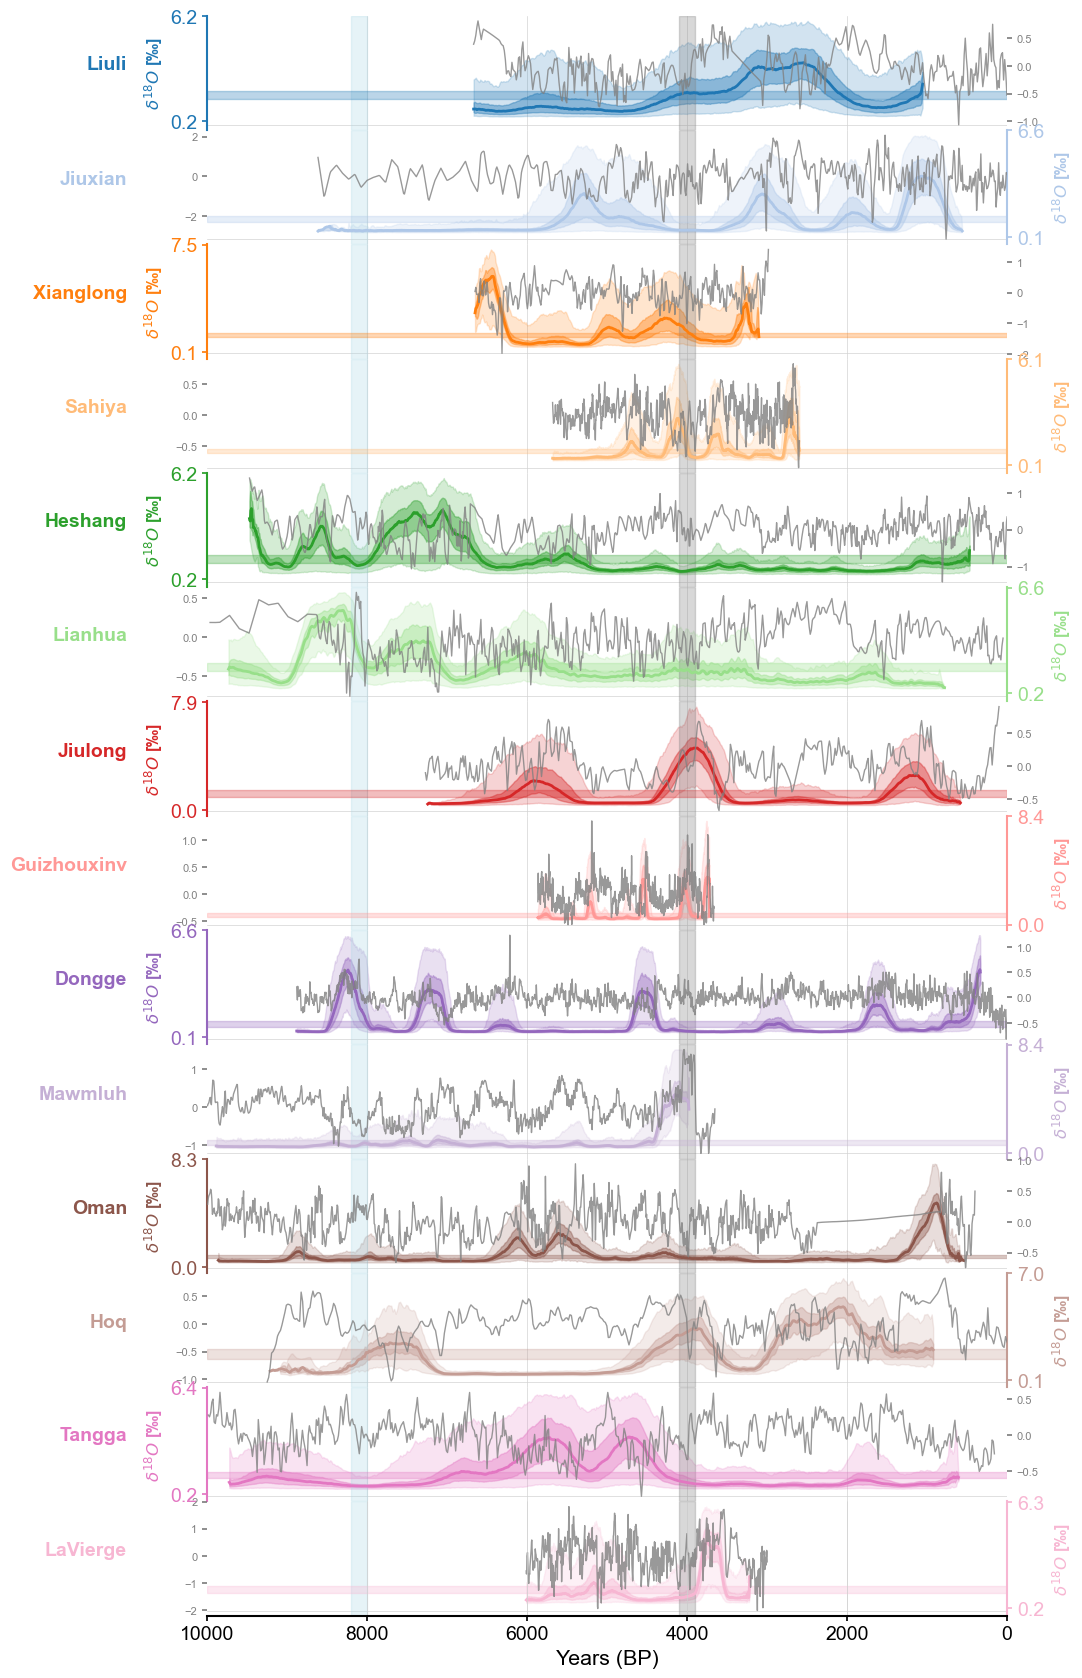

In [11]:
# Create a figure with a specified size
fig = plt.figure(figsize=(8, 16))

# Set up plot parameters
xlim = [0, 10000]
n_ts = len(preprocessed_ens_dict)
fill_between_alpha = 0.2
labels = 'auto'
ylabel_fontsize = 12
spine_lw = 1.5
grid_lw = 0.5
label_x_loc = -0.15
v_shift_factor = 1
linewidth = 1.5

ax = {}
left = 0
width = 1
height = 1 / n_ts
bottom = 1

# Iterate over each pair in preprocessed_series_dict
for idx, pair in enumerate(preprocessed_series_dict.items()):
    label, series = pair
    ens = lerm_ens[label]

    # Calculate the median and confidence interval of the ensemble
    ens_median = ens.common_time().quantiles().series_list[1]
    upper, lower = ammo.utils.sampling.confidence_interval(ens_median)

    color = palette_dict[label]

    bottom -= height * v_shift_factor
    ax[idx] = fig.add_axes([left, bottom, width, height])

    # Plot the ensemble envelope
    ens.common_time(time_axis=preprocessed_series_dict[label].time, bounds_error=False).plot_envelope(ax=ax[idx], shade_clr=color, curve_clr=color)

    # Set plot properties for the main axis
    ax[idx].patch.set_alpha(0)
    ax[idx].set_xlim(xlim)
    time_label = 'Years (BP)'
    value_label = '$\delta^{18} O$ [‰]'
    ax[idx].set_ylabel(value_label, weight='bold', size=ylabel_fontsize)

    # Create a twin y-axis
    ax2 = ax[idx].twinx()
    ax2.grid(False)

    # Plot the series on the twin y-axis
    series.plot(ax=ax2, color='grey', alpha=.8, linestyle='-', linewidth=1, ylabel='')

    # Set y-axis limits and ticks for the main axis
    ylim = ax[idx].get_ylim()
    ax[idx].set_yticks([ylim[0], ylim[-1]])

    # Add labels to the plot
    trans = transforms.blended_transform_factory(ax[idx].transAxes, ax[idx].transData)
    ax[idx].text(-.1, np.mean(ylim), label, horizontalalignment='right', transform=trans, color=color, weight='bold')

    ax[idx].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[idx].grid(False)

    # Set spine and tick properties based on index
    if idx % 2 == 0:
        ax[idx].spines['left'].set_visible(True)
        ax[idx].spines['left'].set_linewidth(spine_lw)
        ax[idx].spines['left'].set_color(color)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].yaxis.set_label_position('left')
        ax[idx].yaxis.tick_left()
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.yaxis.set_label_position('right')
        ax2.yaxis.tick_right()
    else:
        ax[idx].spines['left'].set_visible(False)
        ax[idx].spines['right'].set_visible(True)
        ax[idx].spines['right'].set_linewidth(spine_lw)
        ax[idx].spines['right'].set_color(color)
        ax[idx].yaxis.set_label_position('right')
        ax[idx].yaxis.tick_right()
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.yaxis.set_label_position('left')
        ax2.yaxis.tick_left()

    # Set additional plot properties
    ax[idx].yaxis.label.set_color(color)
    ax[idx].tick_params(axis='y', colors=color)
    ax[idx].spines['top'].set_visible(False)
    ax[idx].spines['bottom'].set_visible(False)
    ax[idx].tick_params(axis='x', which='both', length=0)
    ax[idx].set_xlabel('')
    ax[idx].set_xticklabels([])
    ax[idx].legend([])
    xt = ax[idx].get_xticks()[1:-1]
    for x in xt:
        ax[idx].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].axhline(y=0, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].invert_xaxis()

    # Highlight specific time spans
    ax[idx].axvspan(4100, 3900, color='grey', alpha=0.3)
    ax[idx].axvspan(8200, 8000, color='lightblue', alpha=0.3)

    # Highlight the confidence interval
    ax[idx].axhspan(upper, lower, color=color, alpha=.3)

    # Set properties for the twin y-axis
    ax2.tick_params(axis='y', colors='grey', labelsize=8)
    ylim2 = ax2.get_ylim()
    ax[idx].set_yticks([ylim[0], ylim[-1]])
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.tick_params(axis='x', which='both', length=0)
    ax2.set_xlabel('')
    ax2.set_xticklabels([])
    ax2.legend([])

# Set up the x-axis label at the bottom
bottom -= height * (1 - v_shift_factor)
ax[n_ts] = fig.add_axes([left, bottom, width, height])
ax[n_ts].set_xlabel(time_label)
ax[n_ts].spines['left'].set_visible(False)
ax[n_ts].spines['right'].set_visible(False)
ax[n_ts].spines['bottom'].set_visible(True)
ax[n_ts].spines['bottom'].set_linewidth(spine_lw)
ax[n_ts].set_yticks([])
ax[n_ts].patch.set_alpha(0)
ax[n_ts].set_xlim(xlim)
ax[n_ts].grid(False)
ax[n_ts].tick_params(axis='x', which='both', length=3.5)
xt = ax[n_ts].get_xticks()[1:-1]
for x in xt:
    ax[n_ts].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
ax[n_ts].invert_xaxis()

In [12]:
pyleo.savefig(fig,'../figures/speleothem_lerm.pdf')

Figure saved at: "../../figures/speleothem_lerm.pdf"


In [ ]:
transition_timing_dict = {}

for label,ens in lerm_ens.items():
    transition_timing_list = []
    for series in ens.series_list:
        transitions = detect_transitions(series)
        transition_timing_list.extend(transitions)
    transition_timing_dict[label] = transition_timing_list


In [ ]:
with open('../../data/transition_timing_dict.pkl','wb') as handle:
    pickle.dump(transition_timing_dict,handle)

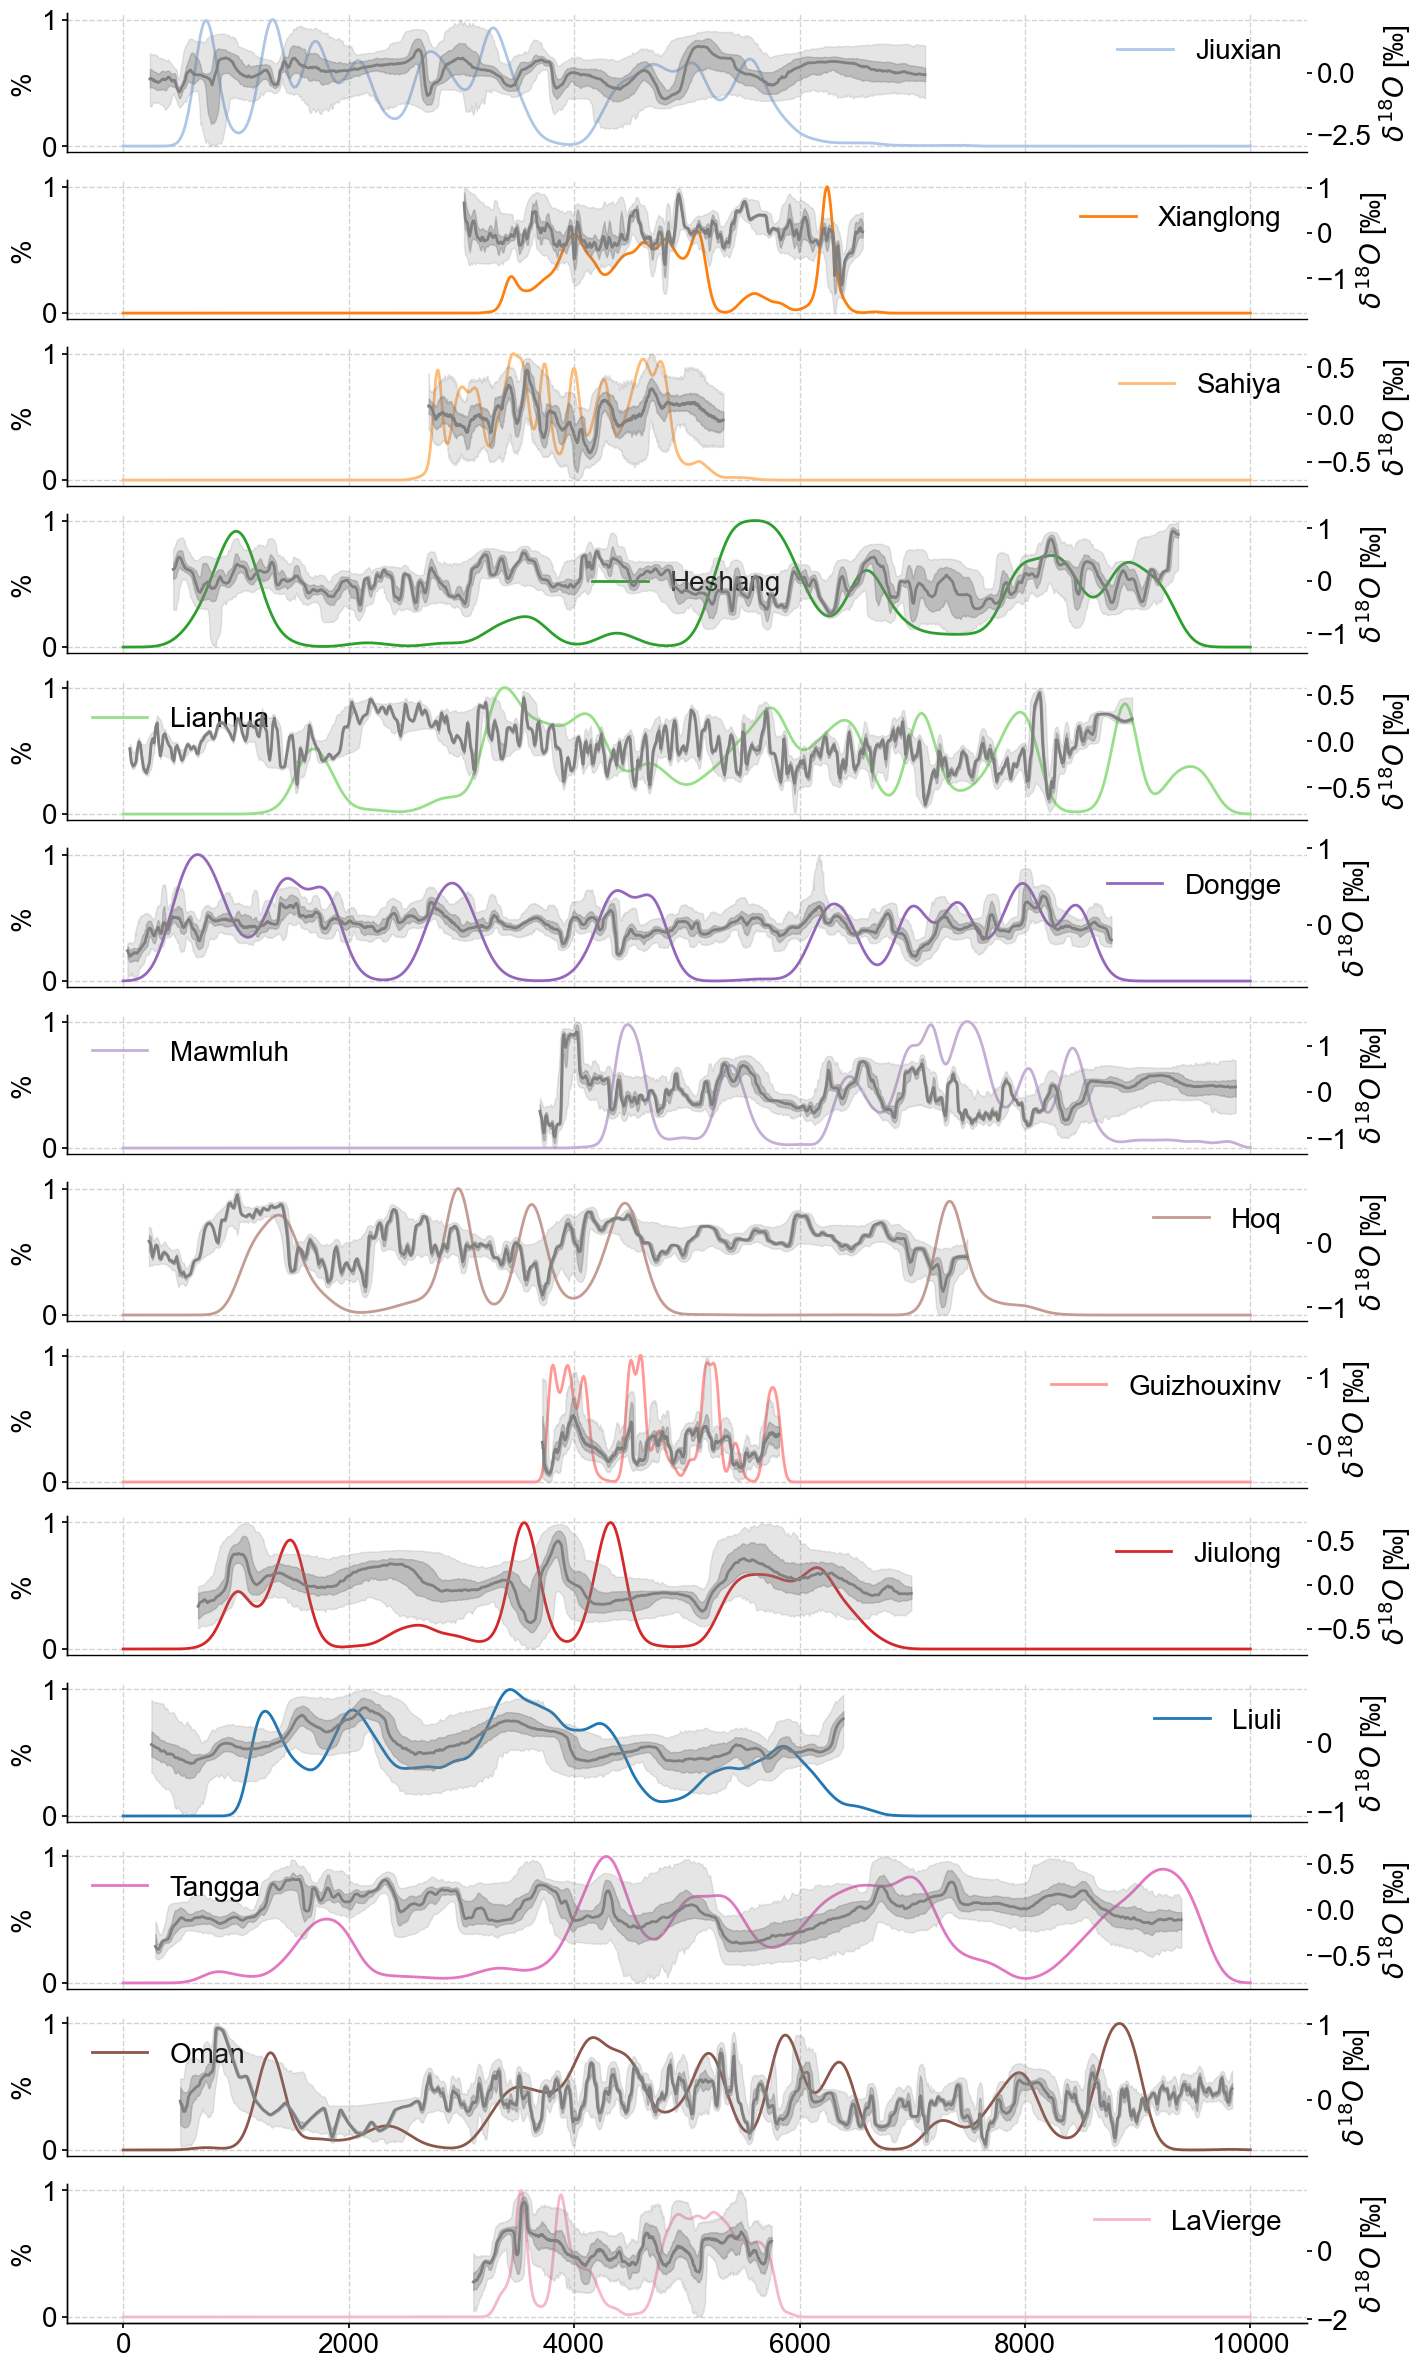

In [ ]:
#Production figure
color_list = sns.color_palette('colorblind',n_colors = len(preprocessed_series_dict.keys()))

SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig,axes = plt.subplots(nrows=len(preprocessed_series_dict.keys()),ncols=1,sharex=True,figsize=(16,30))
cmap = plt.get_cmap('flare')

for idx,pair in enumerate(preprocessed_ens_dict.items()):

    label,ens = pair
    transition_list = transition_timing_dict[label]
    ax = axes[idx]

    color = palette_dict[label]
    kde = stats.gaussian_kde(transition_list,bw_method=.05)
    xaxis = np.linspace(0,10000,1000)
    evaluated = kde.evaluate(xaxis)
    evaluated /= max(evaluated)
    ax.plot(xaxis,evaluated,label=label,color=color)
    ax.set_ylabel('%')
    ax.legend().set_visible(True)

    twin_ax = ax.twinx()
    ens.common_time().plot_envelope(ax=twin_ax,curve_clr='grey',shade_clr='grey',plot_legend=False)
    twin_ax.grid(False)
    twin_ax.legend().set_visible(False)
    
    if idx != len(lerm_ens.keys())-1:
        ax.set_xlabel(None)
        ax.spines[['bottom']].set_visible(False)
        ax.tick_params(bottom=False)
    ax.set_yticks(ticks=np.array([0,1]))